
# Week 2 — Baseline Prediction Models & Evaluation

In this notebook, you will build **baseline prediction models** for financial
returns and evaluate them using **strictly forward-looking (time-series)
validation**.

This week focuses on **evaluation discipline**, not on maximizing performance.


## 1. Imports

In [341]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

plt.style.use("seaborn-v0_8")



## 2. Load data from Week 1

- Reuse the data you created in Week 1.
- You can use one stock of your choice (you can repeat it for multiple stocks if you want and plot them separately)
- Take a long term horizon data set (5-10 years)


In [342]:
assets = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NVDA']
long_term_start = "2015-01-01"
long_term_end = "2024-01-01"
long_term_data = yf.download('AAPL', start=long_term_start, end=long_term_end, auto_adjust=False)['Adj Close']
asset = 'AAPL'

long_term_data = long_term_data.ffill().bfill()

[*********************100%***********************]  1 of 1 completed



## 3. Feature construction

Required features:
- $r_t$
- $r_{t-1}$
- 20-day rolling mean
- 20-day rolling volatility
- 5-day momentum


In [343]:

# TODO: construct features using only past data

ret = long_term_data[asset].diff().dropna()
feature_df = pd.DataFrame({"returns": ret.values}, index=ret.index)

feature_df['returns-lag1'] = feature_df['returns'].shift(1)
feature_df['roll-mean-20'] = feature_df['returns'].rolling(20).mean()
feature_df['vol-20'] = feature_df['returns'].rolling(20).std()
feature_df['momentum-5'] = feature_df['returns'].rolling(5).sum()

feature_df = feature_df.dropna()
target = feature_df['returns'].shift(-1).ffill()


## 4. Naive baselines


In [344]:
# TODO: zero predictor
pred_zero = np.zeros(len(target))
print("RMSE from Zero Predictor:", np.sqrt(mean_squared_error(target, pred_zero)))

RMSE from Zero Predictor: 1.7891952267192688


In [345]:
# TODO: rolling mean predictor
pred_roll_mean = feature_df['roll-mean-20'].values
print("RMSE from Rolling Mean Predictor:", np.sqrt(mean_squared_error(target, pred_roll_mean)))

RMSE from Rolling Mean Predictor: 1.8309298799567124



## 5. Linear models (OLS & Ridge)
Suggested that you review basic linear regression theory as well (resources given in README).

In [346]:

# use LinearRegression from sklearn
ols_model = LinearRegression()

ols_model.fit(feature_df, target)
y_pred = ols_model.predict(feature_df)

mse_ols = mean_squared_error(target, y_pred)
rmse_ols = np.sqrt(mse_ols)

print("OLS RMSE:", rmse_ols)

OLS RMSE: 1.785567314489772



## 6. Tree-based model (Random Forest) (optional)


In [347]:

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)

rf.fit(feature_df, target)
y_pred = rf.predict(feature_df)

mse_rf = mean_squared_error(target, y_pred)
rmse_rf = np.sqrt(mse_rf)

print("RF RMSE:", rmse_rf)

RF RMSE: 1.7354359461101971


## 7. Walk-forward evaluation

- Scikit reference for [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [348]:
# TODO: implement TimeSeriesSplit evaluation
# Walk-forward evaluation with a time-series split
tscv = TimeSeriesSplit(n_splits=100)

rmse_scores = {
    'OLS': [],
    'RF': [],
    'RollingMean': [],
    'Zero': []
}

for train_index, test_index in tscv.split(feature_df):
    X_train, X_test = feature_df.iloc[train_index], feature_df.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    # OLS on training fold
    ols_fold = LinearRegression(n_jobs=-1)
    ols_fold.fit(X_train, y_train)
    pred_ols = ols_fold.predict(X_test)

    rmse_scores['OLS'].append(np.sqrt(mean_squared_error(y_test, pred_ols)))

    # RF on training fold
    rf_fold = RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_leaf=50,
        random_state=42,
        n_jobs=-1
    )
    rf_fold.fit(X_train, y_train)
    pred_rf = rf_fold.predict(X_test)
    rmse_scores['RF'].append(np.sqrt(mean_squared_error(y_test, pred_rf)))

    # Rolling Mean Baseline
    W = 5 # window length
    pred_roll = X_test['returns'].rolling(W).mean().bfill().values
    rmse_scores['RollingMean'].append(np.sqrt(mean_squared_error(y_test, pred_roll)))

    # Zero baseline
    pred_zero = np.zeros_like(y_test)
    rmse_scores['Zero'].append(np.sqrt(mean_squared_error(y_test, pred_zero)))

print("Walk-forward RMSEs (mean over folds):")
for name, scores in rmse_scores.items():
    print(name, np.mean(scores))


Walk-forward RMSEs (mean over folds):
OLS 1.4194881965875936
RF 1.4117788685408883
RollingMean 1.481155356582692
Zero 1.4097140158520833



## 8. Prediction accuracy


In [349]:
# TODO: compute RMSE for all models and compare them
rmse_df = pd.DataFrame(rmse_scores)
display(rmse_df)

,OLS,RF,RollingMean,Zero
0,0.396395,0.391706,0.420592,0.389415
1,0.267049,0.301942,0.313720,0.302707
2,0.325217,0.320816,0.358060,0.316038
3,0.636199,0.556379,0.604562,0.554478
4,0.678991,0.657660,0.775881,0.657623
...,...,...,...,...
95,2.883991,2.905550,3.073472,2.820802
96,2.837931,2.764316,2.955348,2.775021
97,1.708835,1.680756,1.604795,1.680562
98,1.904417,1.838400,1.675050,1.904242


<Axes: >

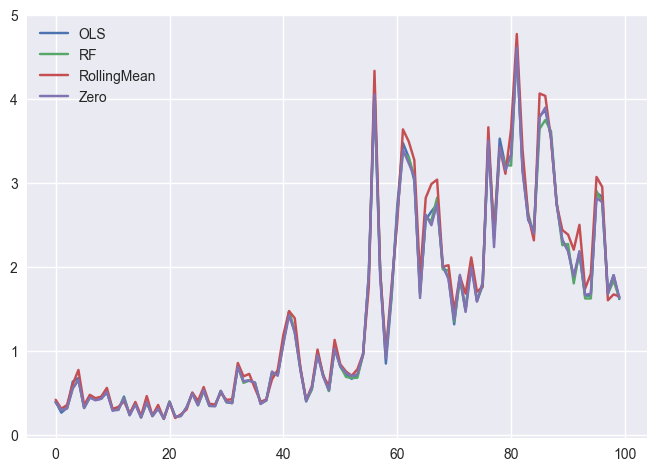

In [350]:
# TODO: plot rolling RMSE vs time for all models to compare their performance across different time periods/regimes
rmse_df.plot()

In [351]:
# Bonus: compute volatility scaled/normalized prediction error: sqrt( ((y_true - y_pred)**2) / (vol_t**2) ) - and compare across models


## 9. Bonus: Looking at a toy strategy based on predictions
Define a simple "all-in" strategy where you go all long (+1) when you predict the stock to be going up, and all short (-1) when you predict the stock to be going down
$$
\text{position}_t = \text{sign}(y_\text{pred})
$$
Then, your returns for the $t$-th day (assuming daily returns) will be $(\text{position}_t \times y_\text{true})$ (note $y_\text{true} = r_t$).

Note that this is extremely simplistic and ignore any predictions related magnitude of expected returns, or expected volatility data etc. It is used only as a demonstration of what a prediction-based strategy may look like.

**Plot your returns using this strategy based on all the models above and compare them!**

In [352]:
# TODO: compute the positions for each model and daily returns


In [353]:
# TODO: plot your returns


## 10. Discussion questions

1. Why do we need naive baselines?
2. How does the evaluation strategy here (walk-forward evaluation) differ from the random training-test dataset splits used in convention ML?
3. *(Addon)* And, why does random splitting technique fail here?
4. Interpret the RMSE values and rolling RMSE plot results very briefly.
5. *(Addon)* Are there periods where model performance degrades noticeably? What might this indicate?
6. Why might Random Forest overfit?
7. *(Bonus)* Two models have similar RMSE, but one makes larger errors primarily during high-volatility periods. Why might this model be *less dangerous* in a portfolio context?